# Unsupervised Discovery of Implicit Gender Bias

### Anjalie Field and Yulia Tsvetkov, EMNLP'2020

The goal of this work is to <span style="color:blue"> unsupervisedly detect subtle gender biases</span> like microaggresions, objectifications and condescenision in 2nd person text. Espeically the biased comment normally associated with previous context, so current classifiers that detect hate speech, offensive language, or negative sentiment cannot detect these comments. Some example biased sentences are:
```
* "Oh, you work at an office? I bet you're a secretary"
* "Total tangent I know, but you're gorgeous"
```
We can see that in these examples, the second segments alone may not be biased, but when we put them in context, they become problematic.

If we could have a automated detection classifier that could detect such biases sentence, that would be beneficial to:
* Make the posters aware of the bias so they will not post them at the first place (proactive response)
* Flag harm comments so readers can filter out biased comments (active response)

A straightforward way is to train a supervised classifier if we have statement and bias label. But the biases are subtle, the implicit nature of bias suggests that even human expert annotations are not always reliable. In addition, it is quite expensive to collect an annotation dataset with a reasonable scale.

In this work, the authors proposed to <span style="color:blue">use an unsupervised method </span>. They proposed to first train a classifier that predicts that gender of the person that the text is addressed to (whether the addressee is male or female). If the classifier makes a prediction with high confidence, the text likely contains bias.

However, confounds in the input text may contain other aspects of information (which is not indicative of bias) that can lead to high-confidence classifier prediction. For example, if the comment is "Bro, golf is better", then the word "bro" can easily indicate the addressee is male but there is no bias. 

To deal with this challenge, this work further propose methods to control confounding variables when training the gender bias classifier. The methodology involves <span style="color:blue">reducing the influence of confounds
through propensity matching and adversarial
learning. </span>

To summarize, the general idea of this paper is that comments contain bias if they are **highly predictive** of gender **despite confound control**.

# Problem Formulation
The primary task is to detect gender bias **in a communicative domain** like social media posts, specifically in texts targeting an addressee (i.e., 2nd-person) without relying on explicit bias annotations. The Following counterfactual is defined accordingly:
* Would the addressee have received different text if their gender were different?


### Notations

Let's consider a setup where our primary text is a **comment written
in reply to text written by someone else**. Each data point contains the following variables:
* OW: “Original Writer”, the person who wrote the original text, e.g., the addressee
* O_TXT: content of the original text
* W_GEN: the gender (M, F) of OW. 
* W_TRAITS: any traits of OW other than gender, e.g., social role, age, nationality.
* COM_TXT: comments replying to O_TXT

For example, in the Figure 1 below, when the comment
“UR hot!” (COM_TXT) is addressed to someone
who said “I love tennis!” (O_TXT), it is an objectification and unsolicited reference to appearance, which could indicate bias. 
<img src="Figure1.png" alt="Figure1" width="400"/>
Not that we use a binary variable for W_GEN because all of the individuals in the corpus identify as men or women, but
our methodology is generalizeable and can be used to examine bias against other genders. 

However, there are some confounding factors affecting the conclusion that are not indicative of gender bias. This is because of correlations between W_GEN and O_TXT, COM_TXT values may contain features that are predictive of W_GEN, but are caused by O_TXT, rather than by W_GEN. For example, if our data set contains more men from Canada than women, the model might learn that references to Canada indicate W_GEN = M. This is one of the confounding variables.

# Data
Here are more examples from the facebook dataset that contains a subsection of the
RtGender corpus (Voigt et al., 2018). Here are two more examples from the dataset:
``` 
1	Teacher : what do they look like ? ( referring to a picture of middle eastern <people> in hijabs ) 
    Student : terrorists . 
    Teacher : i was looking for 'religious' , 'traditional' , or 'worried' . but yes , that too . good , tyler !     	M
2 yeah , but you 're not that kind of native .	M

```
The data contains two subsections: 
* [Politicians] 400K posts and 13.9M replies addressed to 412 then-current U.S. members of Congress, and 
* [Public Figures] 118K posts and 10.7M replies addressed to 105 famous people such as actresses and tennis players.

Table 4 reports details of our data set after preprocessing.
<img src="Table4.png" alt="Figure1" width="300"/>


# Method: Classifier for Addressee Gender Prediction

The input to the prediction model is the following comment, the ouput is the gender of the addressee. we aim to identify bias in the following comment. The authors proposed two methods to control confounds from different perspective:
* Observed confounding variables are balanced through propensity matching
* Latent confounding variables are demoted through adversarial training

## Controlling Observed Confounding Variables through Propnesity Matching

In our problem statement, comments are written in reply to "original text" writtedn by the addressee. Then another writer wrote "comment" to reply to the addressee. Comment content is influenced by both the "original text" and the potential bias factor such as the gender of the addressee. This first method for controlling confounds targets to reduce the influence from the "original text".

The primary method to this is using propensity matching. We discard any comment text training samples whose associated original text is healvily affiliate with only one gender. The goal is to balance the dataset, so that the comment text from male and female has similar probabilities to associate with the original text.

But the problem is it's hard to find comments written by male and females with identical original text in practice (that's why there is bias in the dataset!) 
 
So the propensity score for a comment text is defined as the probability that the writter is female given the original text. 

## Controlling Latent Confounding Variables through Adversarial Training

Comments may also influenced by traits of the addressee such as occupation, nationality, nicknames etc other than gender. These additional factors are unique to individuals and there are many of them, so it's hard to enumerate all of them. We also want to control influence from these other confounding factors other than gender.

Traits are inferred from comments using log-odds scores and represented in a vector. The GAN-like training procedure discourages the model from learning these traits.

# Evaluation

The goal is to have the model predict W_GEN(addresee gender) from COM_TXT(comments), employing propensity matching over O_TXT(original text), word substitutions over COM_TXT, and W_TRAITS(gender traits) demotion. The focus is to evaluate how well the model control cofounds and whether gendered langauge is successfully captured. Confound demotion suggests that our model learns to identify text indicative of gender bias. This is done using a few steps:

<ul>
<li> Observed Confounding Variable Demotion</li>
<li>Latent Confounding Variable Demotion</li>
</ul>


#### Observed Confounding Variable Demotion
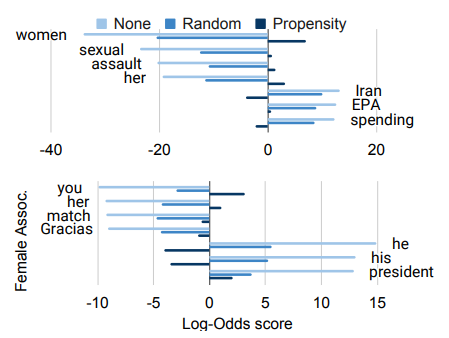


Log-odd scores is being used to measure the association between O_Txt and W_Gen. This measurement is done both pre and post the propensity measure. As a comparison study, scores for a randomly matched data set are shown as well which include O_TXT with equal proportions of F and M labels by random sampling. Propensity matching is shown to change the polarity's direction. for example, words that were originally female-associated (e.g. “her”) become slightly male-associated 

### Latent Confounding Variable Demotion


An evaluation on how well model demotes influence of latent confounding variables is performed on test set. This data is such that OW values in both test and train don't overlap though some amount of W_trait overlap exists. Hence a better importance proves that the demotion was indeed effective such that model learns charecteristics of comments addressed to women rather than charecteristics specific to individual from train data. However **propensity matching** hasn't shown any significant improvement when ablated since the data splits are disjoint deeming the matching approach ineffective.


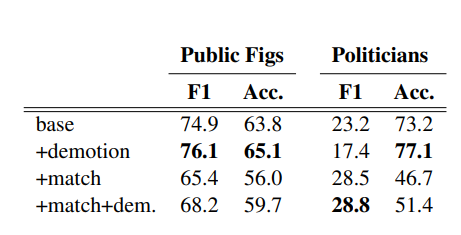


Since the data used is a combination of Politician's and Public Figures, they are evaluated independently and reported in the above table. Here **W_Gen = F** is taken to be the positive class. While a general lack of performance improvement on the test set could indicate bias-free language,  However in this case, bias comments exist and the performance increase shows the model's effectiveness in generalizing beyond tran data and in fact capture characteristics of language addressed towards women. The performance can be seen below.

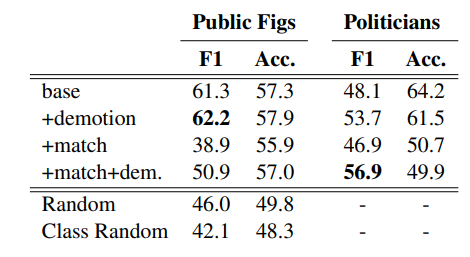


In [ ]:
!python src/train.py \
--data RT_GENDER \
--base_path /home/ma/fairness/unsupervised_gender_bias_models/facebook_wiki \
--train_file train.subs_name2.matched_facebook_wiki.notopics.txt \
--valid_file valid.subs_name2.facebook_wiki.txt \
--test_file test.subs_name2.facebook_wiki.txt \
--model RNN \
--model_name rt_gender_facebook_wiki_matched_notopics.model \
--save_dir /home/ma/fairness/unsupervised_gender_bias_models/facebook_wiki/matched_notopics_subs_name2 \
--batch_size 32 \
--write_attention \
--epochs 5 \
--lr 0.0001 \
--load

### Detection of Sexist Comments

The model is evaluated to study if it's capable of detecting gender-biased language by using it to identify gender-based microaggression. For example, “you’re too pretty to be a computer scientist!

The employed method involved distibgusing gender-tagged microaggression from other forms such as racism-tagged. The model was trained on the original dataset(Politician and public figure) and tested on micro-aggression dataset.Additionally two baseline models **Random** and **class Random**  were used in
the micro-aggression detection task. While incorporating Propensity matching boosted politicans dataset, it performed rather poorly on Public Figures data. A few reasons here being the dataset is smaller or the imbalanced dataset. Additionally since most of the agression is targeted towards the looks, propensity matching technique discards many of the comments thus making the predcition harder. 

### Analysis of Encoded Bias
The main steps involved
<ul>
<li>Identify words that most impact
model confidence</li>
<li>Compare posts surface by our model with prior work on stereotypes</li>
<li>show example posts surfaced by our model</li>
</ul>




#### Influential Words

Words are identified by masking out words from comments in the test set and
examining the impact on prediction score. About 500 comments with prediction(W_GEN) = F are taken. Surface post are built such that each word is masked one-by-one whule constructing the post. Prediction is performed on each of these posts, comparing the predictions in pairs $[x,y_i]$ where x is the original post and $y_i$ is the post with the $i^{th}$ word omitted. This is followed by an average across all 500 comments. The words w with highest differential prediction score tend to associated less to W_GEN = F.

The popular words in the public figures data include *beautiful, bellissima, amore, amo, love, linda, sex* and politicans it included *force,situation,family,love,spouse*

### Comparison to stereotype lexicons

